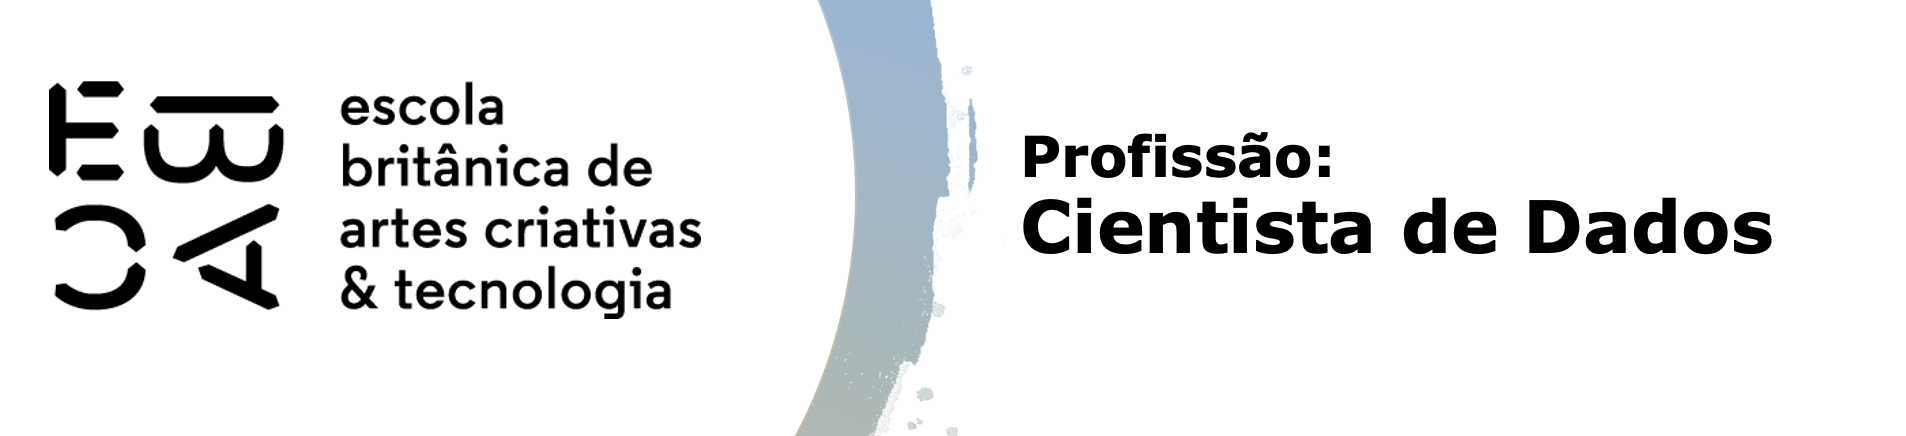

# PCA - Tarefa 02: Classificação de Atividade Humana com PCA






Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

## 1. Importando as bibliotecas e pacotes necessários

In [78]:
!pip install -U scikit-learn

In [79]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
#from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



## 2. Carregando as bases de dados

In [81]:
# Definindo os nomes dos arquivos
filename_features = "./features.txt"
filename_labels = "./activity_labels.txt"

filename_subtrain = "./subject_train.txt"
filename_xtrain = "./X_train.txt"
filename_ytrain = "./y_train.txt"

filename_subtest = "./subject_test.txt"
ffilename_xtest = "./X_test.txt"
filename_ytest = "./y_test.txt"

# Carregando os recursos (features) do arquivo 'features.txt'
features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")

# Carregando os rótulos (labels) do arquivo 'activity_labels.txt'
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Carregando os dados de treinamento
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# Carregando os dados de teste da mesma maneira que os dados de treinamento
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])


<ipython-input-81-502258ac79e2>:14: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
<ipython-input-81-502258ac79e2>:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
<ipython-input-81-502258ac79e2>:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)


## 3. PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [82]:
%%time
# Definindo a função para padronizar os dados
def padroniza(s):
    # Verificando se o desvio padrão é maior que zero
    if s.std() > 0:
        # Padronizando os dados subtraindo a média e dividindo pelo desvio padrão
        s = (s - s.mean())/s.std()
    return s

# Aplicando a função de padronização aos dados de treinamento
# O método 'apply' aplica uma função ao longo de um eixo do DataFrame
X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)

# Aplicando a função de padronização aos dados de teste
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)

# Exibindo as primeiras linhas dos dados de treinamento padronizados
X_train_pad.head()

CPU times: user 1.1 s, sys: 3.48 ms, total: 1.1 s
Wall time: 1.13 s


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


### 3.1 Análise de componentes principais (PCA) para a base de treinamento SEM padronização

In [83]:
%%time


# Instanciando um objeto PCA
pca = PCA()

# Ajustando o objeto PCA aos dados de treinamento não padronizados
perform_pca = pca.fit(X_train)

# Transformando os dados de treinamento usando o objeto PCA ajustado
X_train_pca = perform_pca.transform(X_train)


# Obtendo o número de colunas dos dados de treinamento
n_componentes = X_train.shape[1]

# Criando uma lista de nomes para as componentes principais
nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]

# Visualizando o DataFrame com os dados transformados (componentes) e atribuindo os nomes_pca como nomes das colunas
pd.DataFrame(data=X_train_pca, columns=nomes_pca)

CPU times: user 1.77 s, sys: 211 ms, total: 1.98 s
Wall time: 1.06 s


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,2.945201e-17,6.650219e-17,7.940658e-17,5.693303e-17,1.369110e-17,-1.646317e-15,4.068547e-17,2.678739e-16,1.708650e-16,7.355787e-17
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-5.800068e-17,-3.930680e-17,-1.906868e-18,2.765699e-17,-4.970436e-17,7.981521e-16,-3.768129e-16,-2.009793e-16,1.415755e-17,1.814042e-16
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,9.382782e-17,5.823999e-18,3.153651e-17,1.034335e-17,-5.757571e-17,-1.632267e-15,-2.895455e-16,4.644138e-17,1.524679e-17,1.265979e-16
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,5.065154e-17,9.062953e-17,-3.679664e-17,-1.313170e-17,-5.840322e-17,9.054963e-16,-8.915080e-17,-1.030606e-16,-7.941150e-17,4.285932e-17
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-2.320525e-18,-5.291508e-17,1.893027e-17,5.163516e-18,1.888239e-17,4.979598e-16,1.727184e-18,-9.611008e-17,1.617956e-16,-2.526132e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,7.134597e-17,-1.942045e-17,-6.501534e-17,5.188688e-17,1.151404e-16,-6.337117e-16,2.059157e-17,1.006765e-16,8.272188e-18,5.908956e-18
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,-7.154806e-18,3.446314e-17,3.426557e-17,2.495678e-17,1.446261e-16,-2.350480e-15,1.469938e-16,4.033688e-17,-2.121338e-16,-1.506931e-16
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,-3.791943e-17,-8.607610e-18,5.335309e-17,-7.020937e-18,1.127634e-17,1.892651e-16,3.921526e-16,2.380176e-16,7.089002e-17,-1.207962e-16
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,3.707386e-17,-7.090080e-17,1.333896e-16,-4.267225e-17,3.654337e-17,-3.903514e-15,2.076395e-16,-7.581911e-17,4.855765e-17,-1.580973e-16


#### 3.1.1 Visualizando - SEM padronização

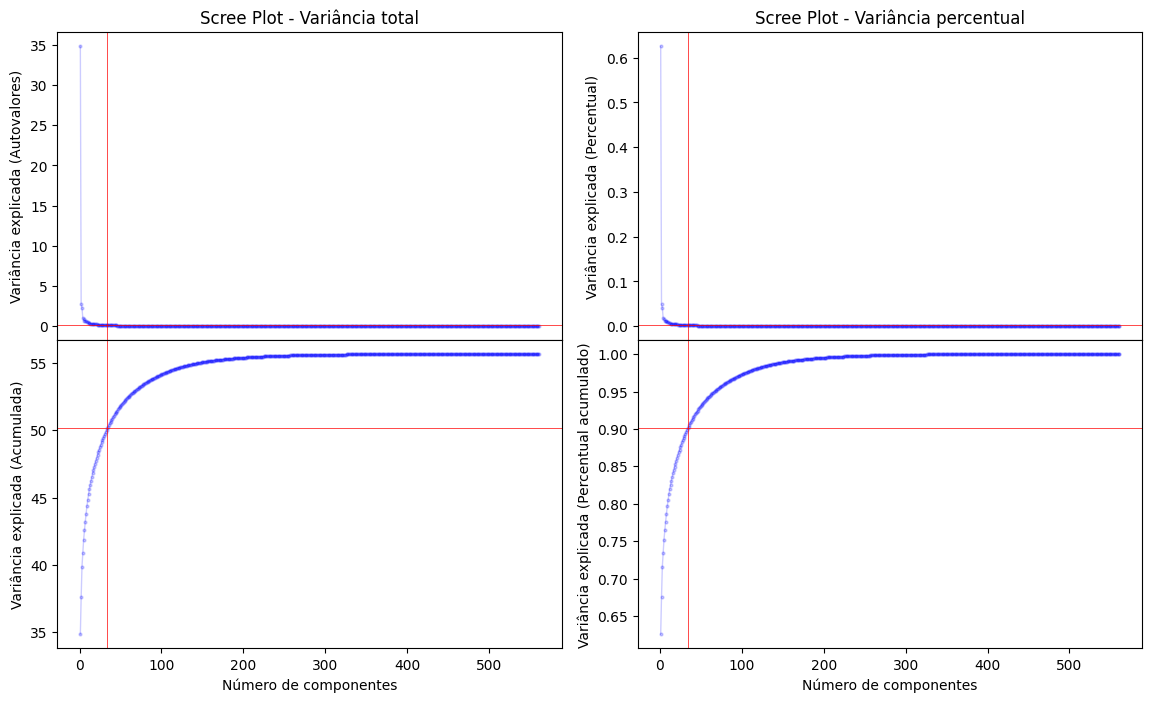

São necessárias 34 componentes para explicar 90% da variância


In [84]:
# Critério: Variância explicada
varexplicada = .90  # Definindo a variância explicada desejada
ncomp_criterio = (perform_pca.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

# Criando uma figura com 2 linhas e 2 colunas de subplots e ajustando o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
num_componentes = np.arange(perform_pca.n_components_) + 1

# Títulos dos gráficos
titulos = ['Scree Plot - Variância total', 'Scree Plot - Variância percentual']
eixos_y = ['Variância explicada (Autovalores)', 'Variância explicada (Percentual)']

for i in range(2):
    # Gráfico da variância nominal e percentual por quantidade de componentes
    ax[0, i].plot(num_componentes, perform_pca.explained_variance_ if i == 0 else perform_pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
    ax[0, i].set_title(titulos[i])
    ax[0, i].set_xlabel('Número de componentes')
    ax[0, i].set_ylabel(eixos_y[i])

    # Gráfico da variância nominal e percentual acumulada por quantidade de componentes
    ax[1, i].plot(num_componentes, perform_pca.explained_variance_.cumsum() if i == 0 else perform_pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
    ax[1, i].set_xlabel('Número de componentes')
    ax[1, i].set_ylabel('Variância explicada (Acumulada)' if i == 0 else 'Variância explicada (Percentual acumulado)')

    # Linhas verticais de referência
    ax[0, i].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
    ax[1, i].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

    # Linhas horizontais de referência
    ax[0, i].axhline(y=perform_pca.explained_variance_[ncomp_criterio-1] if i == 0 else perform_pca.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
    ax[1, i].axhline(y=perform_pca.explained_variance_.cumsum()[ncomp_criterio-1] if i == 0 else perform_pca.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'São necessárias {ncomp_criterio} componentes para explicar 90% da variância')


#### 3.1.2 Estatísticas de variância para cada componente principal

In [85]:
# Calculando a variância, variância acumulada, variância percentual e variância percentual acumulada da última componente principal
variancia               = perform_pca.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = perform_pca.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = perform_pca.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = perform_pca.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

# Imprimindo o número de componentes e as estatísticas de variância
print(f'Número de componentes:...................... {ncomp_criterio}')
print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')


Número de componentes:...................... 34
Variância da última CP:..................... 0.13
Variância acumulada da última CP:........... 50.15
Variância percentual da última CP:.......... 0.24%
Variância percentual acumulada da última CP: 90.09%


In [86]:
# Criando um DataFrame com as estatísticas de variância para cada componente principal
pca_raw = pd.DataFrame(data={'variancia': perform_pca.explained_variance_[:ncomp_criterio],
                             'variancia_acumulada': perform_pca.explained_variance_.cumsum()[:ncomp_criterio],
                             'pct_variancia': perform_pca.explained_variance_ratio_[:ncomp_criterio],
                             'pct_variancia_acumulada': perform_pca.explained_variance_ratio_.cumsum()[:ncomp_criterio]},
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587
6,0.708152,42.548514,0.012721,0.764308
7,0.655053,43.203567,0.011767,0.776075
8,0.595090,43.798657,0.010690,0.786765
9,0.539647,44.338304,0.009694,0.796459


### 3.2 Análise de componentes principais (PCA) para a base de treinamento COM padronização

In [92]:
%%time

X_train_pad = X_train_pad.transpose()
# Instanciando um objeto PCA
pca_pad = PCA()

# Ajustando o objeto PCA aos dados de treinamento não padronizados
perform_pca_pad = pca_pad.fit(X_train_pad)

# Transformando os dados de treinamento usando o objeto PCA ajustado
X_train_pca = perform_pca_pad.transform(X_train_pad)


# Obtendo o número de colunas dos dados de treinamento
n_componentes_pad = X_train_pad.shape[1]

# Criando uma lista de nomes para as componentes principais
nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes))]

# Visualizando o DataFrame com os dados transformados (componentes) e atribuindo os nomes_pca como nomes das colunas
pd.DataFrame(data=X_train_pca, columns=nomes_pca_pad)


CPU times: user 1.73 s, sys: 283 ms, total: 2.01 s
Wall time: 1.67 s


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,2.229812e-17,-4.739070e-16,8.999183e-17,-1.894375e-16,-7.140373e-17,5.164284e-17,-1.471356e-16,1.840855e-17,4.957448e-15,-3.460216e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-3.275833e-16,1.523676e-18,-7.285452e-17,1.941602e-16,-1.336415e-16,3.794217e-17,8.092806e-17,-6.010147e-17,-7.614209e-16,3.023353e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-1.419148e-16,8.675175e-17,-8.315142e-17,1.577885e-16,1.701729e-16,-2.298117e-16,-4.792719e-16,-1.566884e-17,-3.272938e-15,4.063014e-17
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,2.672547e-17,-2.121543e-16,-3.856394e-16,1.570934e-16,-4.067373e-16,3.576900e-17,-4.744167e-16,-1.903323e-16,-6.457022e-16,-1.148727e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-2.783091e-17,3.816430e-16,-4.025376e-16,3.136307e-16,-8.166578e-17,-8.542124e-18,-2.379606e-17,-6.103379e-17,-2.848513e-15,1.765876e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,-3.743312e-16,1.569194e-16,1.685714e-16,-3.599487e-16,1.171363e-16,-3.398971e-16,-2.407298e-16,5.368850e-17,-5.275977e-15,3.597164e-16
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,2.975874e-16,-6.141995e-17,-1.239823e-16,1.544043e-16,2.787481e-16,-2.053497e-16,-2.944162e-16,-5.983296e-17,-3.398478e-15,5.223499e-16
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,2.615520e-18,2.589568e-17,-2.246664e-16,-7.451618e-17,2.541458e-16,3.520356e-17,-6.512063e-17,1.262042e-16,8.335097e-16,7.661691e-16
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,-2.039575e-16,-1.771094e-17,-2.693419e-17,9.010825e-17,1.266930e-16,5.857336e-17,2.142399e-16,-6.983377e-17,3.883012e-15,3.377711e-16


3.2.1 Visualizando - COM padronização

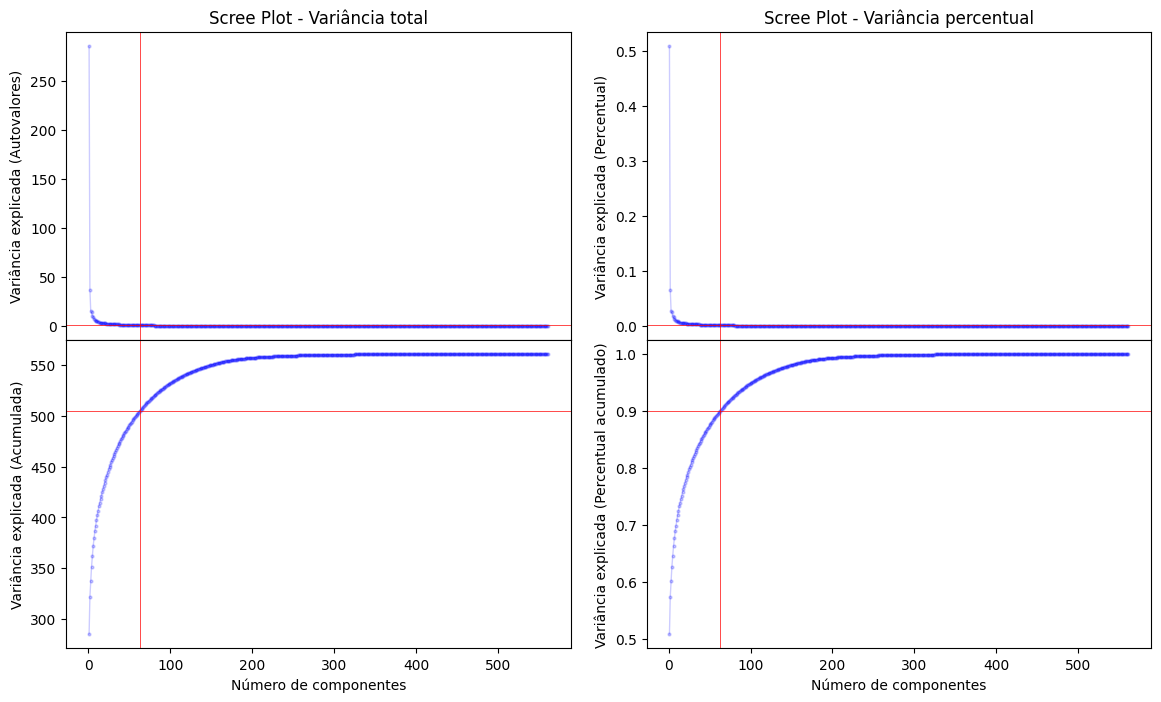

Para explicar 90% da variância com a padronização das variáveis, são necessárias 63 componentes.
Para o critério de autovalor > 1, são necessárias 61 componentes.


In [93]:
# Critério: Variância explicada
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio_pad = (perform_pca_pad.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

# Criando uma figura com 2 linhas e 2 colunas de subplots e ajustando o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
num_componentes_pad = np.arange(perform_pca_pad.n_components_) + 1

# Títulos dos gráficos
titulos = ['Scree Plot - Variância total', 'Scree Plot - Variância percentual']
eixos_y = ['Variância explicada (Autovalores)', 'Variância explicada (Percentual)']

for i in range(2):
    # Gráfico da variância nominal e percentual por quantidade de componentes
    ax[0, i].plot(num_componentes_pad, perform_pca_pad.explained_variance_ if i == 0 else perform_pca_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
    ax[0, i].set_title(titulos[i])
    ax[0, i].set_xlabel('Número de componentes')
    ax[0, i].set_ylabel(eixos_y[i])

    # Gráfico da variância nominal e percentual acumulada por quantidade de componentes
    ax[1, i].plot(num_componentes_pad, perform_pca_pad.explained_variance_.cumsum() if i == 0 else perform_pca_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
    ax[1, i].set_xlabel('Número de componentes')
    ax[1, i].set_ylabel('Variância explicada (Acumulada)' if i == 0 else 'Variância explicada (Percentual acumulado)')

    # Linhas verticais de referência
    ax[0, i].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
    ax[1, i].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)

    # Linhas horizontais de referência
    ax[0, i].axhline(y=perform_pca_pad.explained_variance_[ncomp_criterio_pad-1] if i == 0 else perform_pca_pad.explained_variance_ratio_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
    ax[1, i].axhline(y=perform_pca_pad.explained_variance_.cumsum()[ncomp_criterio_pad-1] if i == 0 else perform_pca_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância com a padronização das variáveis, são necessárias {ncomp_criterio_pad} componentes.')

criterio_autovalor = (perform_pca_pad.explained_variance_ratio_ > 1 / perform_pca_pad.n_components_).sum()
print(f'Para o critério de autovalor > 1, são necessárias {criterio_autovalor} componentes.')


3.2.2 Estatísticas de variância para cada componente principal

In [94]:
# Calculando a variância, variância acumulada, variância percentual e variância percentual acumulada da última componente principal
variancia               = perform_pca_pad.explained_variance_[ncomp_criterio_pad - 1]
variancia_acumulada     = perform_pca_pad.explained_variance_.cumsum()[ncomp_criterio_pad - 1]
pct_variancia           = perform_pca_pad.explained_variance_ratio_[ncomp_criterio_pad - 1]
pct_variancia_acumulada = perform_pca_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad - 1]

# Imprimindo o número de componentes e as estatísticas de variância
print(f'Número de componentes:...................... {ncomp_criterio_pad}')
print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')


Número de componentes:...................... 63
Variância da última CP:..................... 0.99
Variância acumulada da última CP:........... 505.20
Variância percentual da última CP:.......... 0.18%
Variância percentual acumulada da última CP: 90.05%


In [90]:
# Criando um DataFrame com as estatísticas de variância para cada componente principal
pca_pad = pd.DataFrame(data={'variancia': perform_pca_pad.explained_variance_[:ncomp_criterio_pad],
                             'variancia_acumulada': perform_pca_pad.explained_variance_.cumsum()[:ncomp_criterio_pad],
                             'pct_variancia': perform_pca_pad.explained_variance_ratio_[:ncomp_criterio_pad],
                             'pct_variancia_acumulada': perform_pca_pad.explained_variance_ratio_.cumsum()[:ncomp_criterio_pad]},
                       index=list(range(1, ncomp_criterio_pad+1)))
pca_pad.index.name = 'CP'
pca_pad

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,1886.148492,1886.148492,0.346117,0.346117
2,453.240417,2339.388909,0.083172,0.429289
3,198.479795,2537.868704,0.036422,0.465711
4,177.513977,2715.382681,0.032575,0.498285
5,139.050146,2854.432827,0.025516,0.523802
...,...,...,...,...
76,10.241614,4869.850635,0.001879,0.893640
77,10.210815,4880.061449,0.001874,0.895514
78,9.984690,4890.046140,0.001832,0.897346


### 3.3 Análise

Para o conjunto de dados **com padronização**, 63 componentes são necessárias para explicar 90,05% da variância. A variância da última componente principal é 0,99 e a variância acumulada da última componente principal é 505,20.

Já para o conjunto de dados **sem padronização**, 80 componentes são necessárias para explicar 90,10% da variância. A variância da última componente principal é 9,74 e a variância acumulada da última componente principal é 4909,70.

> A diferença no número de componentes necessárias para explicar aproximadamente a mesma quantidade de variância (90%) ***sugere que a padronização dos dados teve um impacto significativo na análise de componentes principais***.

Além disso, a variância da última componente principal e a variância acumulada da última componente principal são significativamente maiores para o conjunto de dados sem padronização. Isso é esperado, pois a padronização dos dados coloca todas as variáveis na mesma escala, o que geralmente resulta em uma variância menor.

> Em resumo, esses resultados destacam a importância da padronização na análise de componentes principais e mostram como ela pode afetar o número de componentes necessárias para explicar uma determinada quantidade de variância.

## 4. Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [106]:
%%time

# Criando os classificadores de árvore de decisão
clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_raw = DecisionTreeClassifier(ccp_alpha=0.001)

# Treinando e testando o classificador com dados padronizados
clf_pad.fit(X_train_pca_pad, y_train)
y_pred_train_pad = clf_pad.predict(X_train_pca_pad)
y_pred_test_pad = clf_pad.predict(X_test_pca_pad)

# Calculando a acurácia na base de treino e teste para dados padronizados
acc_train_pad = accuracy_score(y_train, y_pred_train_pad)
acc_test_pad = accuracy_score(y_test, y_pred_test_pad)

print('COM PADRONIZAÇÃO')
print(f'Acurácia na base de treino: {acc_train_pad}')
print(f'Acurácia na base de teste: {acc_test_pad}\n')

# Treinando e testando o classificador com dados não padronizados
clf_raw.fit(X_train_pca_raw, y_train)
y_pred_train_raw = clf_raw.predict(X_train_pca_raw)
y_pred_test_raw = clf_raw.predict(X_test_pca_raw)

# Calculando a acurácia na base de treino e teste para dados não padronizados
acc_train_raw = accuracy_score(y_train, y_pred_train_raw)
acc_test_raw = accuracy_score(y_test, y_pred_test_raw)

print('SEM PADRONIZAÇÃO')
print(f'Acurácia na base de treino: {acc_train_raw}')
print(f'Acurácia na base de teste: {acc_test_raw}\n')


COM PADRONIZAÇÃO
Acurácia na base de treino: 0.860310119695321
Acurácia na base de teste: 0.7750254496097726

SEM PADRONIZAÇÃO
Acurácia na base de treino: 0.8911860718171926
Acurácia na base de teste: 0.8221920597217509

CPU times: user 433 ms, sys: 0 ns, total: 433 ms
Wall time: 701 ms


#### 4.1 Comparação de Classificadores por meio de Matrizes de Confusão e Acurácia

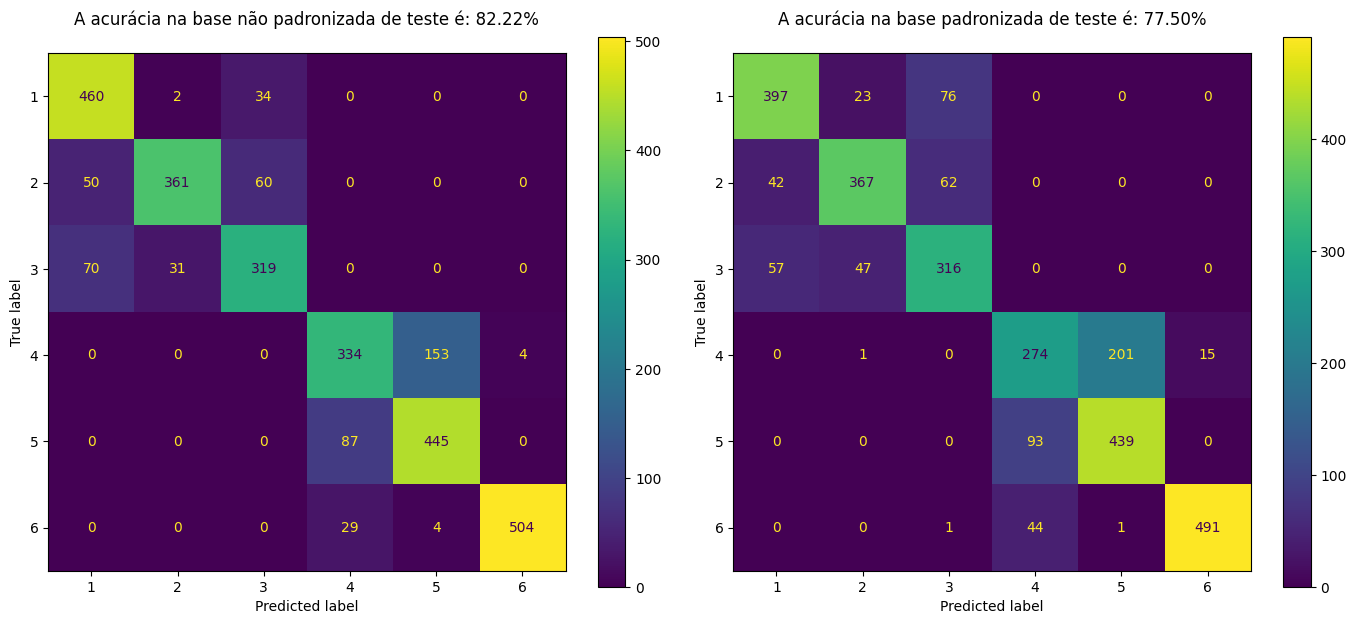

In [107]:
# Realizando a previsão dos dados
y_pred_pad = clf_pad.predict(X_test_pca_pad)
y_pred_raw = clf_raw.predict(X_test_pca_raw)

# Cria uma figura com 1 linha e 2 colunas e define o tamanho da figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Configurando o título do primeiro subgráfico com a acurácia na base não padronizada de teste
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_test, y_pred_raw) * 100:.2f}%\n')

# Plota a matriz de confusão do primeiro subgráfico
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_raw, ax=ax[0])

# Configura o título do segundo subgráfico com a acurácia na base padronizada de teste
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_test, y_pred_pad) * 100:.2f}%\n')

# Plota a matriz de confusão do segundo subgráfico
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pad, ax=ax[1])

# Ajusta o layout dos subgráficos para evitar sobreposições
plt.tight_layout()

# Exibe o gráfico
plt.show()



### 4.2 Análise

Para os dados ***com padronização***, a acurácia na base de treino é de aproximadamente 86,03% e na base de teste é de aproximadamente 77,50%. Isso indica que o modelo *tem um bom desempenho nos dados de treino*, mas seu *desempenho diminui um pouco nos dados de teste*. Isso pode ser um sinal de sobreajuste, o que significa que o modelo pode estar capturando ruído além do sinal nos dados de treino.

Para os dados ***sem padronização***, a acurácia na base de treino é de aproximadamente 89,12% e na base de teste é de aproximadamente 82,25%. Isso indica que o modelo tem um desempenho um pouco melhor nos dados de treino e de teste em comparação com o modelo treinado com dados padronizados.

> Em geral, esses resultados sugerem que a padronização dos dados pode não ser necessária para este conjunto de dados específico ao usar um classificador de árvore de decisão.